In [10]:
import torch as ch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from data_utils import AmazonWrapper, RatingModel
import torch.nn as nn
from livelossplot import PlotLosses

In [2]:
def train_model(model, t_loader, v_loader, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    acc_fn = lambda x, y: ch.sum((y == (x >= 0)))
    
    liveloss = PlotLosses()
    for e in range(epochs):
        # Train
        logs = {}
        running_loss, running_acc = 0.0, 0.0
        num_samples = 0
        model.train()
        for (x, y, _) in t_loader:
            x, y = x.cuda(), y.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(x)[:, 0]
            loss = loss_fn(outputs, y.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += acc_fn(outputs, y)
            num_samples += x.shape[0]
            
            logs['loss'] = running_loss / num_samples
            logs['accuracy'] = running_acc / num_samples

        # Validation
        model.eval()
        running_loss, running_acc = 0.0, 0.0
        num_samples = 0
        for (x, y, _) in v_loader:
            x, y = x.cuda(), y.cuda()

            with ch.no_grad():
                outputs = model(x)[:, 0]
                loss = loss_fn(outputs, y.float())
                running_loss += loss.item()
                running_acc += acc_fn(outputs, y)
                num_samples += x.shape[0]

        logs['val_loss'] = running_loss / num_samples
        logs['val_accuracy'] = running_acc / num_samples
    
        liveloss.update(logs)
        liveloss.send()
    return model

In [3]:
do = AmazonWrapper("./data/roberta-base")
do.load_all_data()

Reusing dataset amazon_reviews_multi (/u/as9rw/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/f3357bd271e187385a38574fe31b8fb10055303f67fa9fce55e84d08c4870efd)


In [4]:
batch_size = 256
train_loader = do.get_train_loader(batch_size)
val_loader = do.get_val_loader(5000)
test_loader = do.get_test_loader(5000)

In [7]:
model = RatingModel(768, binary=True).cuda()

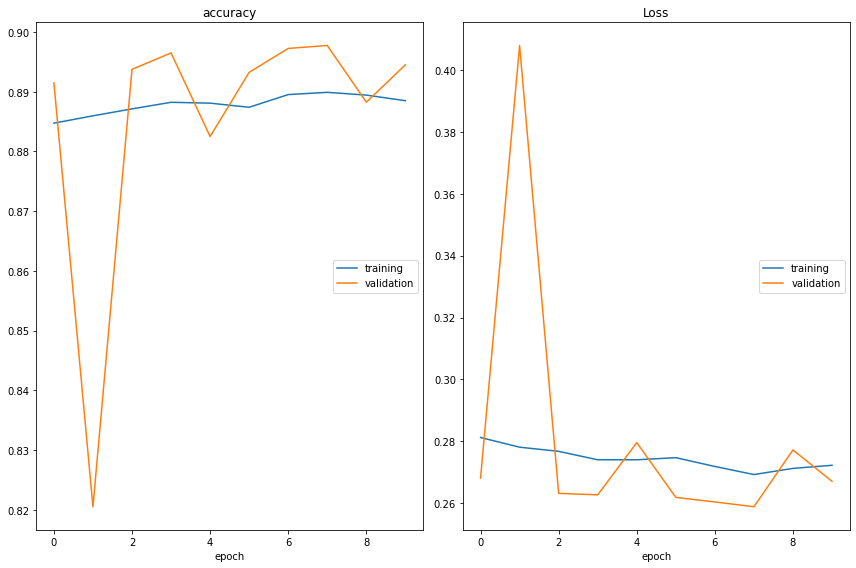

accuracy
	training         	 (min:    0.885, max:    0.890, cur:    0.888)
	validation       	 (min:    0.821, max:    0.898, cur:    0.895)
Loss
	training         	 (min:    0.269, max:    0.281, cur:    0.272)
	validation       	 (min:    0.259, max:    0.408, cur:    0.267)


In [9]:
tm = train_model(model, train_loader, val_loader, epochs=10)

In [123]:
def get_weight_layers(m):
    dims, weights, biases = [], [], []
    for name, param in m.named_parameters():
        if "weight" in name:
            weights.append(param.data.detach().T)
            dims.append(weights[-1].shape[0])
        if "bias" in name:
            biases.append(ch.unsqueeze(param.data.detach(), 0))
    
    cctd = []
    for w, b in zip(weights, biases):
        cctd.append(ch.cat((w, b), 0).T)

    return dims, cctd

In [211]:
dims, params = get_weight_layers(tm)

In [216]:
# Currently works with a batch size of 1
# Shouldn't be that big a deal, since here's only a few
# Couple hundred models

class PermInvModel(nn.Module):
    def __init__(self, dims):
        super(PermInvModel, self).__init__()
        self.dims = dims
        self.layers = []
        prev_layer = 0
        
        def make_mini(y):
            return nn.Sequential(
                nn.Linear(y, 64),
                nn.ReLU(),
                nn.Linear(64, 8),
                nn.ReLU(),
                nn.Dropout()
            )
        
        for i, dim in enumerate(self.dims):
            # 1 for bias
            # prev_layer for previous layer
            # input dimension per neuron
            if i > 0:
                prev_layer = 8 * dim
            self.layers.append(make_mini(prev_layer + 1 + dim))
            
        self.layers = nn.ModuleList(self.layers)
        # Final network to combine them all together
        self.rho = nn.Linear(8 * len(dims), 1)
            
    def forward(self, params):
        reps = []
        prev_layer_rep = None
    
        for param, layer in zip(params, self.layers):
            # Process nodes in this layer
            if prev_layer_rep is None:
                processed = layer(param)
            else:
                # Include previous layer representation
                prev_layer_rep = prev_layer_rep.repeat(param.shape[0], 1)
                param_eff = ch.cat((param, prev_layer_rep), 1)
                processed = layer(param_eff)
            
            # Store this layer's representation
            reps.append(ch.sum(processed, 0))
            
            prev_layer_rep = processed.flatten()
            prev_layer_rep = ch.unsqueeze(prev_layer_rep, 0)
        
        reps_c = ch.unsqueeze(ch.cat(reps), 0)
        return self.rho(reps_c)

In [217]:
pin = PermInvModel(dims).cuda()

In [218]:
rep = pin(params)
print(rep)

tensor([[-0.2526]], device='cuda:0', grad_fn=<AddmmBackward>)
